In [25]:
from langgraph.graph import START,END,StateGraph
from langchain_groq import ChatGroq
from dotenv import load_dotenv
from typing import TypedDict,Literal, Annotated
from langchain_core.messages import SystemMessage, HumanMessage
from operator import add

In [26]:
load_dotenv()

True

In [27]:
generator_llm = ChatGroq(model='openai/gpt-oss-120b')
evaluator_llm = ChatGroq(model='openai/gpt-oss-120b')
optimizer_llm = ChatGroq(model='openai/gpt-oss-120b')

In [28]:
from pydantic import BaseModel, Field

class TweetEvaluation(BaseModel):
    evaluation: Literal["approved", "needs_improvement"] = Field(..., description="Final evaluation result.")
    feedback: str = Field(..., description="feedback for the tweet.")

In [29]:
structured_evaluator_llm = evaluator_llm.with_structured_output(TweetEvaluation)

In [37]:
# state
class TweetState(TypedDict):

    topic: str
    tweet: str
    evaluation: Literal["approved", "needs_improvement"]
    feedback: str
    iteration: int
    max_iteration: int

    tweet_history: Annotated[list[str], add]
    feedback_history: Annotated[list[str],add]

In [38]:
def generate_tweet(state: TweetState):

    # prompt
    messages = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""
Write a short, original, and hilarious tweet on the topic: "{state['topic']}".

Rules:
- Do NOT use question-answer format.
- Max 280 characters.
- Use observational humor, irony, sarcasm, or cultural references.
- Think in meme logic, punchlines, or relatable takes.
- Use simple, day to day english
""")
    ]

    # send generator_llm
    response = generator_llm.invoke(messages).content

    # return response
    return {'tweet': response, 'tweet_history': [response]}

In [39]:
def evaluate_tweet(state: TweetState):

    # prompt
    messages = [
    SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
    HumanMessage(content=f"""
Evaluate the following tweet:

Tweet: "{state['tweet']}"

Use the criteria below to evaluate the tweet:

1. Originality - Is this fresh, or have you seen it a hundred times before?  
2. Humor - Did it genuinely make you smile, laugh, or chuckle?  
3. Punchiness - Is it short, sharp, and scroll-stopping?  
4. Virality Potential - Would people retweet or share it?  
5. Format - Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

Auto-reject if:
- It's written in question-answer format (e.g., "Why did..." or "What happens when...")
- It exceeds 280 characters
- It reads like a traditional setup-punchline joke
- Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

### Respond ONLY in structured format:
- evaluation: "approved" or "needs_improvement"  
- feedback: One paragraph explaining the strengths and weaknesses 
""")
]

    response = structured_evaluator_llm.invoke(messages)

    return {'evaluation':response.evaluation, 'feedback': response.feedback, 'feedback_history': [response.feedback]} 

In [40]:
def optimize_tweet(state: TweetState):

    messages = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""
Improve the tweet based on this feedback:
"{state['feedback']}"

Topic: "{state['topic']}"
Original Tweet:
{state['tweet']}

Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
""")
    ]

    response = optimizer_llm.invoke(messages).content
    iteration = state['iteration'] + 1

    return {'tweet': response, 'iteration': iteration, 'tweet_history': [response]}

In [41]:
def route_evaluation(state: TweetState):

    if state['evaluation'] == 'approved' or state['iteration'] >= state['max_iteration']:
        return 'approved'
    else:
        return 'needs_improvement'

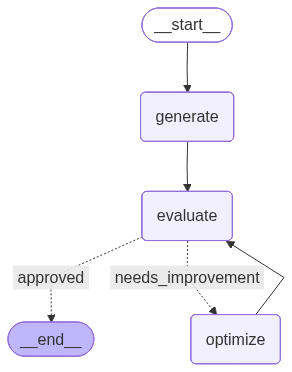

In [42]:
graph = StateGraph(TweetState)

graph.add_node('generate', generate_tweet)
graph.add_node('evaluate', evaluate_tweet)
graph.add_node('optimize', optimize_tweet)

graph.add_edge(START, 'generate')
graph.add_edge('generate', 'evaluate')

graph.add_conditional_edges('evaluate', route_evaluation, {'approved': END, 'needs_improvement': 'optimize'})
graph.add_edge('optimize', 'evaluate')

workflow = graph.compile()

workflow

In [47]:
initial_state = {
    "topic": "Indain Railway",
    "iteration": 1,
    "max_iteration": 5
}
result = workflow.invoke(initial_state)

In [48]:
result

{'topic': 'Indain Railway',
 'tweet': 'Indian Railways: where the train arrives fashionably late, the snack cart is a culinary adventure, and the seat is a yoga class in disguise. Bonus: free strangers’ perfume and a nonstop soundtrack of horns. 🚂😂',
 'evaluation': 'approved',
 'feedback': 'The tweet feels fresh enough—while train‑delay jokes are common, the combo of “fashionably late,” “culinary adventure,” and “yoga‑class seat” adds a novel spin. It lands a solid chuckle with vivid, absurd details and the emojis amplify the humor. It’s a bit wordy for maximum scroll‑stopping punch, but it stays under the character limit and avoids a classic setup‑punchline structure, making it shareable for anyone who’s endured Indian Railways. Overall it’s a strong, retweet‑worthy slice of relatable satire.',
 'iteration': 1,
 'max_iteration': 5,
 'tweet_history': ['Indian Railways: where the train arrives fashionably late, the snack cart is a culinary adventure, and the seat is a yoga class in disg